In [120]:
import os 
import numpy as np 
import pandas as pd 
import seaborn as sns 
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

In [122]:
plays = pd.read_csv('plays.csv')
players = pd.read_csv('players.csv')
playerplay = pd.read_csv('player_play.csv')
tracking_data = pd.read_csv('tracking_week_1.csv')

In [123]:
playerposition = players[['nflId','position']]

In [124]:
filteredtrack = tracking_data[['gameId','playId','frameId','nflId','displayName','x','y','event']]

In [125]:
filteredtrack = pd.merge(
    filteredtrack,
    playerposition,
    how='left',
    left_on=['nflId'],
    right_on=['nflId']
)

In [126]:
filteredtrack = filteredtrack[(filteredtrack['position']=="WR") | (filteredtrack['position']=="TE") | (filteredtrack['position']=="RB")]

In [127]:
motionplayers = playerplay[playerplay['motionSinceLineset']==True]

In [128]:
positions = players[['nflId','position']]

In [129]:
motionplayers = pd.merge(
    motionplayers,
    positions,
    how = "left",
    left_on=['nflId'],
    right_on=['nflId']
)

In [130]:
motionplayers = motionplayers[(motionplayers['position']=="WR") | (motionplayers['position']=="TE") | (motionplayers['position']=="RB")]

In [131]:
motiontracking = pd.merge(
    filteredtrack,
    motionplayers[['gameId','playId','nflId','motionSinceLineset','inMotionAtBallSnap']],
    how="inner",
    left_on=['gameId','playId','nflId'],
    right_on=['gameId','playId','nflId']
)

In [132]:
def filter_motion_to_snap(group):
    group = group.sort_values(by='frameId').reset_index(drop=True)
    line_set_indices = group[group['event'] == 'line_set'].index
    snap_indices = group[group['event'] == 'ball_snap'].index
    
    filtered_rows = []
    for start_idx in line_set_indices:
        snap_idx = snap_indices[snap_indices > start_idx].min()
        if pd.notna(snap_idx):
            filtered_rows.extend(group.loc[start_idx:snap_idx].index)
    return group.loc[filtered_rows]
filtered_df = motiontracking.groupby(['gameId', 'playId']).apply(filter_motion_to_snap).reset_index(drop=True)

In [133]:
filtered_df[['gameId','playId']].drop_duplicates().shape

(1076, 2)

In [139]:
filtered_df.head(75)

gameId  playId  frameId    nflId       displayName      x      y  \
0   2022090800      56       76  42489.0      Stefon Diggs  87.02  27.91   
1   2022090800      56       77  42489.0      Stefon Diggs  87.04  28.36   
2   2022090800      56       78  42489.0      Stefon Diggs  87.06  28.82   
3   2022090800      56       79  42489.0      Stefon Diggs  87.07  29.27   
4   2022090800      56       80  42489.0      Stefon Diggs  87.09  29.73   
..         ...     ...      ...      ...               ...    ...    ...   
70  2022090800      56      146  42489.0      Stefon Diggs  86.24  43.65   
71  2022090800      80       23  47857.0  Devin Singletary  81.74  39.38   
72  2022090800      80       24  47857.0  Devin Singletary  81.74  39.39   
73  2022090800      80       25  47857.0  Devin Singletary  81.74  39.39   
74  2022090800      80       26  47857.0  Devin Singletary  81.74  39.39   

        event position motionSinceLineset inMotionAtBallSnap  
0    line_set       WR               True              False  
1         NaN       WR               True              False  
2         NaN       WR               True              False  
3         NaN       WR               True              False  
4         NaN       WR               True              False  
..        ...      ...                ...                ...  
70  ball_snap       WR               True              False  
71   line_set       RB               True               True  
72        NaN       RB               True               True  
73        NaN       RB               True               True  
74        NaN       RB               True               True  

[75 rows x 11 columns]

In [ ]:
from math import sqrt

def total_distance(df):
    results = []
    temp_distances = []
    start_index = 0  

    for i in range(len(df) - 1):
        x_diff = df.iloc[i + 1]["x"] - df.iloc[i]["x"]
        y_diff = df.iloc[i + 1]["y"] - df.iloc[i]["y"]
        temp_distances.append(sqrt(x_diff**2 + y_diff**2))
        
     
        if df.iloc[i + 1]["event"] == "line_set":
            if temp_distances: 
                results.append({
                    "playId": df.iloc[start_index]["playId"],
                    "nflId": df.iloc[start_index]["nflId"],
                    "total_distance": sum(temp_distances),
                })
            temp_distances = []  
            start_index = i + 1  

    
    if temp_distances:
        results.append({
            "playId": df.iloc[start_index]["playId"],
            "nflId": df.iloc[start_index]["nflId"],
            "total_distance": sum(temp_distances),
        })

    return pd.DataFrame(results)  


In [197]:
total_distance_final = total_distance(filtered_df)

KeyboardInterrupt: 

In [198]:
total_distance_final.head(10)

playId    nflId  total_distance
0      56  42489.0       22.138798
1      80  47857.0       55.299840
2     212  47879.0       21.079664
3     236  52536.0       29.596483
4     299  44881.0       20.693509
5     299  53678.0       10.090079
6     299  43399.0     2736.776968
7     299  53678.0       10.090079
8     299  43399.0     2736.989773
9     299  43399.0     2743.767335

In [199]:
unique_dist_rows = total_distance_final.drop_duplicates(subset=['nflId', 'playId'])

In [145]:
unique_dist_rows.head(10)

playId    nflId  total_distance
0       56  42489.0       22.138798
1       80  47857.0       55.299840
2      212  47879.0       21.079664
3      236  52536.0       29.596483
4      299  44881.0       20.693509
5      299  53678.0       10.090079
6      299  43399.0     2736.776968
10     343  44881.0       14.690872
11     364  44881.0       49.293067
12     393  44881.0       28.820243

In [200]:
filtered_df

gameId  playId  frameId    nflId   displayName      x      y  \
0       2022090800      56       76  42489.0  Stefon Diggs  87.02  27.91   
1       2022090800      56       77  42489.0  Stefon Diggs  87.04  28.36   
2       2022090800      56       78  42489.0  Stefon Diggs  87.06  28.82   
3       2022090800      56       79  42489.0  Stefon Diggs  87.07  29.27   
4       2022090800      56       80  42489.0  Stefon Diggs  87.09  29.73   
...            ...     ...      ...      ...           ...    ...    ...   
162169  2022091200    3723      306  52454.0   K.J. Hamler  71.56  39.21   
162170  2022091200    3723      307  52454.0   K.J. Hamler  71.56  39.21   
162171  2022091200    3723      308  52454.0   K.J. Hamler  71.56  39.21   
162172  2022091200    3723      309  52454.0   K.J. Hamler  71.56  39.21   
162173  2022091200    3723      310  52454.0   K.J. Hamler  71.56  39.21   

            event position motionSinceLineset inMotionAtBallSnap  
0        line_set       WR               True              False  
1             NaN       WR               True              False  
2             NaN       WR               True              False  
3             NaN       WR               True              False  
4             NaN       WR               True              False  
...           ...      ...                ...                ...  
162169        NaN       WR               True              False  
162170        NaN       WR               True              False  
162171        NaN       WR               True              False  
162172        NaN       WR               True              False  
162173  ball_snap       WR               True              False  

[162174 rows x 11 columns]

In [217]:
motionstats = filtered_df.groupby(['gameId', 'playId', 'nflId','position'])['y'].agg(['first', 'last', 'max', 'min']).reset_index()

In [218]:
motionstats

gameId  playId    nflId position  first   last    max    min
0     2022090800      56  42489.0       WR  27.91  43.65  43.67  27.91
1     2022090800      80  47857.0       RB  39.38  31.54  39.41  28.69
2     2022090800     212  47879.0       TE  23.83  32.83  32.83  23.83
3     2022090800     236  52536.0       WR  40.09  35.27  40.09  35.27
4     2022090800     299  43399.0       TE  23.81  18.99  23.81  18.86
...          ...     ...      ...      ...    ...    ...    ...    ...
1328  2022091200    3382  46109.0       WR  29.27  33.27  33.27  29.27
1329  2022091200    3491  46096.0       RB  20.99  27.25  27.25  20.99
1330  2022091200    3553  52423.0       WR  33.44  28.83  33.56  28.83
1331  2022091200    3596  52423.0       WR  34.88  16.78  34.88  16.78
1332  2022091200    3723  52454.0       WR  38.56  39.21  39.21  33.32

[1333 rows x 8 columns]

In [219]:
motionstats['direction_change'] = np.where((motionstats['last'] > motionstats['first']) & (motionstats['max'] > (motionstats['last'] + 1)),
    True,
    np.where((motionstats['last'] <= motionstats['first']) & (motionstats['min'] < (motionstats['last'] - 1)),True,False)
)


In [220]:
motionstats = pd.merge(
    motionstats,
    playerplay[['gameId','playId','nflId','inMotionAtBallSnap']],
    how="left",
    left_on=['gameId','playId','nflId'],
    right_on=['gameId','playId','nflId']
)

In [221]:
final_motionstats = pd.merge(
    motionstats,
    unique_dist_rows[['total_distance','playId','nflId']],
    how="left",
    left_on=['playId','nflId'],
    right_on=['playId','nflId']
)

In [222]:
final_motionstats['total_distance'] = final_motionstats['total_distance'].clip(upper=100)
final_motionstats

gameId  playId    nflId position  first   last    max    min  \
0     2022090800      56  42489.0       WR  27.91  43.65  43.67  27.91   
1     2022090800      80  47857.0       RB  39.38  31.54  39.41  28.69   
2     2022090800     212  47879.0       TE  23.83  32.83  32.83  23.83   
3     2022090800     236  52536.0       WR  40.09  35.27  40.09  35.27   
4     2022090800     299  43399.0       TE  23.81  18.99  23.81  18.86   
...          ...     ...      ...      ...    ...    ...    ...    ...   
1328  2022091200    3382  46109.0       WR  29.27  33.27  33.27  29.27   
1329  2022091200    3491  46096.0       RB  20.99  27.25  27.25  20.99   
1330  2022091200    3553  52423.0       WR  33.44  28.83  33.56  28.83   
1331  2022091200    3596  52423.0       WR  34.88  16.78  34.88  16.78   
1332  2022091200    3723  52454.0       WR  38.56  39.21  39.21  33.32   

      direction_change inMotionAtBallSnap  total_distance  
0                False              False       22.138798  
1                 True               True       55.299840  
2                False               True       21.079664  
3                False               True       29.596483  
4                False              False      100.000000  
...                ...                ...             ...  
1328             False               True       23.669269  
1329             False               True       61.233260  
1330             False               True       14.006074  
1331             False               True       44.163469  
1332             False              False       13.929426  

[1333 rows x 11 columns]

In [223]:
final_df = final_motionstats

In [224]:
final_motionstats = final_motionstats.drop_duplicates(subset=['nflId', 'playId'])

In [225]:
final_df = pd.get_dummies(final_motionstats, columns=['position'], prefix='pos', drop_first=True)

In [226]:
final_df

gameId  playId    nflId  first   last    max    min  \
0     2022090800      56  42489.0  27.91  43.65  43.67  27.91   
1     2022090800      80  47857.0  39.38  31.54  39.41  28.69   
2     2022090800     212  47879.0  23.83  32.83  32.83  23.83   
3     2022090800     236  52536.0  40.09  35.27  40.09  35.27   
4     2022090800     299  43399.0  23.81  18.99  23.81  18.86   
...          ...     ...      ...    ...    ...    ...    ...   
1328  2022091200    3382  46109.0  29.27  33.27  33.27  29.27   
1329  2022091200    3491  46096.0  20.99  27.25  27.25  20.99   
1330  2022091200    3553  52423.0  33.44  28.83  33.56  28.83   
1331  2022091200    3596  52423.0  34.88  16.78  34.88  16.78   
1332  2022091200    3723  52454.0  38.56  39.21  39.21  33.32   

      direction_change inMotionAtBallSnap  total_distance  pos_TE  pos_WR  
0                False              False       22.138798       0       1  
1                 True               True       55.299840       0       0  
2                False               True       21.079664       1       0  
3                False               True       29.596483       0       1  
4                False              False      100.000000       1       0  
...                ...                ...             ...     ...     ...  
1328             False               True       23.669269       0       1  
1329             False               True       61.233260       0       0  
1330             False               True       14.006074       0       1  
1331             False               True       44.163469       0       1  
1332             False              False       13.929426       0       1  

[1333 rows x 12 columns]

In [227]:
final_df['direction_change'] = final_df['direction_change'].astype(int)
final_df['inMotionAtBallSnap'] = final_df['inMotionAtBallSnap'].astype(int)

scaler = StandardScaler()
motion_scaled = scaler.fit_transform(final_df)
kmeans = KMeans(n_clusters=7, random_state=0)
final_df['cluster'] = kmeans.fit_predict(motion_scaled)


final_df

gameId  playId    nflId  first   last    max    min  \
0     2022090800      56  42489.0  27.91  43.65  43.67  27.91   
1     2022090800      80  47857.0  39.38  31.54  39.41  28.69   
2     2022090800     212  47879.0  23.83  32.83  32.83  23.83   
3     2022090800     236  52536.0  40.09  35.27  40.09  35.27   
4     2022090800     299  43399.0  23.81  18.99  23.81  18.86   
...          ...     ...      ...    ...    ...    ...    ...   
1328  2022091200    3382  46109.0  29.27  33.27  33.27  29.27   
1329  2022091200    3491  46096.0  20.99  27.25  27.25  20.99   
1330  2022091200    3553  52423.0  33.44  28.83  33.56  28.83   
1331  2022091200    3596  52423.0  34.88  16.78  34.88  16.78   
1332  2022091200    3723  52454.0  38.56  39.21  39.21  33.32   

      direction_change  inMotionAtBallSnap  total_distance  pos_TE  pos_WR  \
0                    0                   0       22.138798       0       1   
1                    1                   1       55.299840       0       0   
2                    0                   1       21.079664       1       0   
3                    0                   1       29.596483       0       1   
4                    0                   0      100.000000       1       0   
...                ...                 ...             ...     ...     ...   
1328                 0                   1       23.669269       0       1   
1329                 0                   1       61.233260       0       0   
1330                 0                   1       14.006074       0       1   
1331                 0                   1       44.163469       0       1   
1332                 0                   0       13.929426       0       1   

      cluster  
0           3  
1           5  
2           3  
3           3  
4           3  
...       ...  
1328        6  
1329        6  
1330        6  
1331        6  
1332        4  

[1333 rows x 13 columns]

In [ ]:
final_df.to_csv('week1motion.csv',index=False)

In [228]:
final_df[['min','max']] = motionstats[['min','max']]

In [229]:
cluster_means = final_df.groupby('cluster').agg(
    first_mean=('first', 'mean'),
    last_mean=('last', 'mean'),
    direction_change_mean=('direction_change', 'mean'),
    move_at_snap_mean=('inMotionAtBallSnap','mean'),
    total_total_distance =('total_distance','mean'),
    position = ('total_distance','median'),
    count=('first', 'size')
)

cluster_means

first_mean  last_mean  direction_change_mean  move_at_snap_mean  \
cluster                                                                    
0         26.291390  26.358969                    0.0           0.000000   
1         24.829807  25.724353                    0.0           0.258953   
2         15.171687  19.565188                    0.0           0.706250   
3         26.020845  26.183099                    0.0           0.492958   
4         38.943069  35.819653                    0.0           0.430693   
5         28.496667  26.707564                    1.0           0.602564   
6         29.256186  26.845508                    0.0           1.000000   

         total_total_distance   position  count  
cluster                                          
0                   43.105611  31.950490    223  
1                   35.882280  23.810393    363  
2                   35.908359  24.358602    160  
3                   36.636410  23.307326     71  
4                   34.945495  23.647750    202  
5                   47.496071  38.760347     78  
6                   35.308581  26.366268    236

/var/folders/rh/5hh6kw1x191g30wf_hfx_b6c0000gn/T/ipykernel_38654/2081820207.py:21: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()  # Ensure labels fit properly


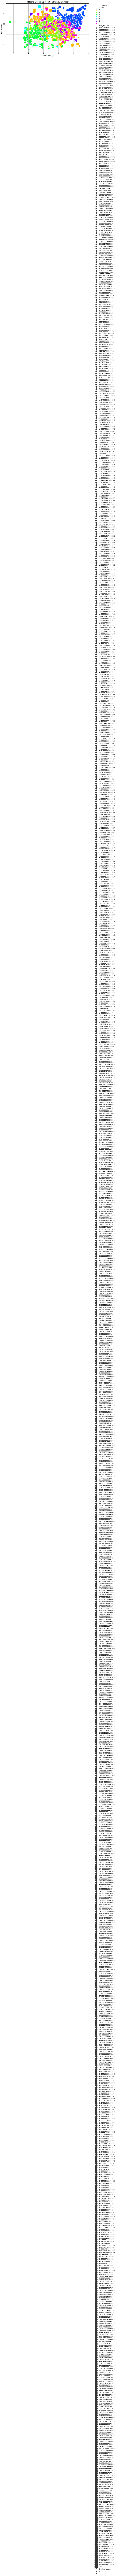

In [230]:
palette = sns.color_palette("hsv", n_colors=7)
plt.figure(figsize=(10, 6))

sns.scatterplot(
    data=final_df,
    x='first', 
    y='last', 
    hue='cluster', 
    palette=palette,
    style='direction_change',  # Different markers for direction change
    size='total_distance',     # Marker size reflects total distance
    sizes=(50, 500),           # Scale marker size between 50 and 500
    legend="full"
)

plt.title("K-Means Clustering of Motion Data (5 Clusters)")
plt.xlabel("First Position (y)")
plt.ylabel("Last Position (y)")
plt.legend(title="Cluster", loc="best", bbox_to_anchor=(1.05, 1))  # Adjust legend position
plt.grid(True)
plt.tight_layout()  # Ensure labels fit properly
plt.show()
